# Analyzing the Netflix Data

In [1]:
import os
import numpy as np
import pandas as pd

#location of data files
dbfs_dir = 's3://thrinathfinalp/'
movieTitles_filename = dbfs_dir + 'movie_titles.txt'
trainingRatings_filename = dbfs_dir + 'TrainingRatings.txt'
testingRatings_filename = dbfs_dir + 'TestingRatings.txt'

In [2]:
#define the schemas

from pyspark.sql.types import *

movieTitles_df_schema = StructType(
  [StructField('ID', IntegerType()),
   StructField('Release_Year', DateType()),
   StructField('title', StringType())]
)

trainingRatings_df_schema = StructType(
  [StructField('movieId', IntegerType()),
   StructField('userId', IntegerType()),
   StructField('rating', DoubleType())]
)

testingRatings_df_schema = StructType(
  [StructField('movieId', IntegerType()),
   StructField('userId', IntegerType()),
   StructField('rating', DoubleType())]
)

In [3]:
from pyspark.sql.functions import regexp_extract
from pyspark.sql.types import *

raw_movieTitles_df = sqlContext.read.format('csv').options(header=True, inferSchema=False).schema(movieTitles_df_schema).load(movieTitles_filename)
movieTitles_df = raw_movieTitles_df.drop('Release_Year')

trainingRatings_df = sqlContext.read.format('csv').options(header=True, inferSchema=False).schema(trainingRatings_df_schema).load(trainingRatings_filename)

testingRatings_df = sqlContext.read.format('csv').options(header=True, inferSchema=False).schema(testingRatings_df_schema).load(testingRatings_filename)

movieTitles_df.cache()
trainingRatings_df.cache()
testingRatings_df.cache()

movies_count = movieTitles_df.count()
trainingRatings_count = trainingRatings_df.count()
testingRatings_count = testingRatings_df.count()

assert movieTitles_df.is_cached
assert trainingRatings_df.is_cached
assert testingRatings_df.is_cached

print ('There are %s movies and %s Training_ratings and %s Testing_ratings rows in the datasets' % (movies_count, trainingRatings_count, testingRatings_count))

print ('Movies:')
movieTitles_df.show(3, truncate=False)

print ('Training_Ratings:')
trainingRatings_df.show(3, truncate=False)

print ('Testing_Ratings:')
testingRatings_df.show(3, truncate=False)

There are 17769 movies and 3255351 Training_ratings and 100477 Testing_ratings rows in the datasets
Movies:
+---+----------------------------+
|ID |title                       |
+---+----------------------------+
|2  |Isle of Man TT 2004 Review  |
|3  |Character                   |
|4  |Paula Abdul's Get Up & Dance|
+---+----------------------------+
only showing top 3 rows

Training_Ratings:
+-------+-------+------+
|movieId|userId |rating|
+-------+-------+------+
|8      |1395430|2.0   |
|8      |1205593|4.0   |
|8      |1488844|4.0   |
+-------+-------+------+
only showing top 3 rows

Testing_Ratings:
+-------+-------+------+
|movieId|userId |rating|
+-------+-------+------+
|8      |2149668|3.0   |
|8      |1089184|3.0   |
|8      |2465894|3.0   |
+-------+-------+------+
only showing top 3 rows



# Distinct Movies and  distinct Users in the  Training set (TrainingRatings.txt) and Testing set (TestingRatings.txt)

In [4]:
# getting the  movie count as unique to plot
movie_Unique_count = movieTitles_df.select("ID").distinct().count()
print("There are %s distinct_movies in Movie Titles dataset: "% (movie_Unique_count))

tr_movie_Unique_count = trainingRatings_df.select("movieId").distinct().count()
tr_user_Unique_count = testingRatings_df.select("userId").distinct().count()
tr_rating_Unique_count = testingRatings_df.select("rating").distinct().count()
print ('There are %s distinct_movies and %s distinct_Users and %s distinct_Ratings in the Training dataset' % (tr_movie_Unique_count, tr_user_Unique_count, tr_rating_Unique_count))

ts_movie_Unique_count = testingRatings_df.select("movieId").distinct().count()
ts_user_Unique_count = testingRatings_df.select("userId").distinct().count()
ts_rating_Unique_count = testingRatings_df.select("rating").distinct().count()
print ('There are %s distinct_movies and %s distinct_Users and %s distinct_Ratings in the Testing dataset' % (ts_movie_Unique_count, ts_user_Unique_count, ts_rating_Unique_count))


21/12/15 21:52:42 WARN Utils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.debug.maxToStringFields' in SparkEnv.conf.


There are 17769 distinct_movies in Movie Titles dataset: 


There are 1821 distinct_movies and 27555 distinct_Users and 5 distinct_Ratings in the Training dataset
There are 1701 distinct_movies and 27555 distinct_Users and 5 distinct_Ratings in the Testing dataset


In [5]:
#pip install seaborn

In [6]:
import pyspark.sql.functions as F
user_avg = trainingRatings_df.groupby('userId')\
             .agg(F.avg('rating').alias('mean_Rating'))\
             .orderBy(F.col('userId')).cache()
user_avg.show()

[Stage 57:==============================================>       (174 + 8) / 200]

+------+------------------+
|userId|       mean_Rating|
+------+------------------+
|     7|3.9038461538461537|
|    79| 3.630952380952381|
|   199| 3.943661971830986|
|   481| 4.351351351351352|
|   769| 3.193877551020408|
|   906|3.8333333333333335|
|  1310|3.4743589743589745|
|  1333|2.6734006734006734|
|  1427|3.5616438356164384|
|  1442| 4.362068965517241|
|  1457|3.5764705882352943|
|  1500|3.7111111111111112|
|  1527|3.6666666666666665|
|  1918|2.9220779220779223|
|  2000|3.6991150442477876|
|  2128|3.5294117647058822|
|  2213|3.9206349206349205|
|  2225|3.3563218390804597|
|  2307|3.7466666666666666|
|  2455| 3.409448818897638|
+------+------------------+
only showing top 20 rows



In [7]:
user_avg.describe('mean_Rating').show()

[Stage 61:===============================================>      (175 + 8) / 200]

+-------+-------------------+
|summary|        mean_Rating|
+-------+-------------------+
|  count|              28978|
|   mean| 3.5160354185440443|
| stddev|0.43468236507005115|
|    min|                1.0|
|    max|                5.0|
+-------+-------------------+



In [8]:
import pyspark.sql.functions as F
item_avg = trainingRatings_df.groupby('movieId')\
             .agg(F.avg('rating').alias('mean_Rating'))\
             .orderBy(F.col('movieId')).cache()
item_avg.show()

[Stage 69:========================================>             (151 + 8) / 200]

+-------+------------------+
|movieId|       mean_Rating|
+-------+------------------+
|      8|3.0558303886925797|
|     28| 3.760127409343352|
|     43| 2.310344827586207|
|     48|3.6206482593037217|
|     61|2.3859649122807016|
|     64| 2.466666666666667|
|     66|2.1384615384615384|
|     92|  3.08955223880597|
|     96|3.0136986301369864|
|    111|3.0373038930854155|
|    122|2.9027291812456264|
|    123|2.7641509433962264|
|    127| 2.626614261650758|
|    140|2.3902439024390243|
|    145|  2.99290780141844|
|    154|2.7586206896551726|
|    156| 3.354724757138652|
|    174| 2.899159663865546|
|    185| 2.976499690785405|
|    192|               3.0|
+-------+------------------+
only showing top 20 rows



In [9]:
item_avg.describe('mean_Rating').show()

+-------+------------------+
|summary|       mean_Rating|
+-------+------------------+
|  count|              1821|
|   mean|  3.05814236365502|
| stddev|0.5390238424652063|
|    min|1.4672897196261683|
|    max|               4.5|
+-------+------------------+



In [10]:
pandas_tr_df = trainingRatings_df.toPandas()
print("Training_PandasDF")
pandas_tr_df.head(3)

Training_PandasDF


,movieId,userId,rating
0,8,1395430,2.0
1,8,1205593,4.0
2,8,1488844,4.0


In [11]:
pandas_ts_df = testingRatings_df.toPandas()
print("Testing_PandasDF")
pandas_ts_df.head(3)

Testing_PandasDF


,movieId,userId,rating
0,8,2149668,3.0
1,8,1089184,3.0
2,8,2465894,3.0


In [12]:
pandas_ts_df.groupby('movieId')['userId'].count().sort_values(ascending=False).reset_index(name='userIdCount').head()

,movieId,userIdCount
0,6971,811
1,4640,756
2,6287,737
3,9728,706
4,8915,695


In [13]:
pandas_tr_df.groupby('userId')['movieId'].count().sort_values().reset_index(name='movieId_Count').head()

,userId,movieId_Count
0,202623,68
1,2474140,69
2,1665014,69
3,1405451,69
4,693787,69


Text(0, 0.5, 'RatingCount')

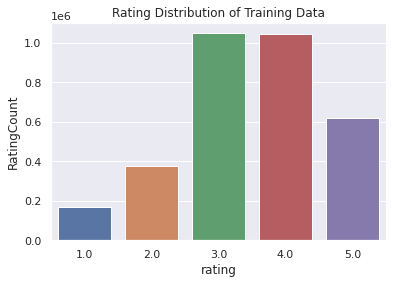

In [14]:
import seaborn as sns
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="rating", data=pandas_tr_df)
ax.set_title('Rating Distribution of Training Data')
ax.set_ylabel('RatingCount')

Text(0, 0.5, 'RatingCount')

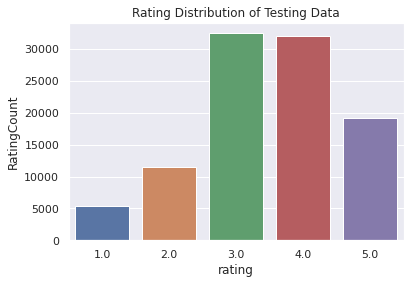

In [15]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="rating", data=pandas_ts_df)
ax.set_title('Rating Distribution of Testing Data')
ax.set_ylabel('RatingCount')

In [16]:
pandas_tr_df['rating'].describe()

count    3.255351e+06
mean     3.481188e+00
std      1.082873e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

In [17]:
pandas_ts_df['rating'].describe()

count    100477.000000
mean          3.479483
std           1.085257
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

In [18]:
from pyspark.sql import functions as F
trainingRatings_df.groupBy("userId").count().filter("count < 70").show(25, truncate = False)
#Get MOvieIds and Ratings in training dataset for the given test user 202623
#trainingRatings_df[trainingRatings_df.userId.isin("202623")].collect()

+-------+-----+
|userId |count|
+-------+-----+
|1922286|69   |
|1382057|69   |
|1714390|69   |
|202623 |68   |
|2508962|69   |
|1893836|69   |
|2474140|69   |
|1569522|69   |
|886158 |69   |
|693787 |69   |
|2596719|69   |
|731941 |69   |
|1583736|69   |
|2638916|69   |
|2021184|69   |
|1665014|69   |
|482107 |69   |
|2220157|69   |
|205302 |69   |
|65076  |69   |
|1260877|69   |
|1405451|69   |
|615780 |69   |
|2364883|69   |
|822391 |69   |
+-------+-----+



In [20]:
# We'll hold out 60% for training, 20% of our data for validation, and leave 20% for testing
#since we have training and testing datasets separately, I am not going to split the dataset

trainingRatings_df.show(3)
testingRatings_df.show(3)

"""
seed = 1800009193
(split_60_df, split_a_20_df, split_b_20_df) = trainingRatings_df.randomSplit([6.0, 2.0, 2.0], seed)

# Let's cache these datasets for performance
training_df = split_60_df.cache()
validation_df = split_a_20_df.cache()
test_df = split_b_20_df.cache()

print('Training: {0}, validation: {1}, test: {2}\n'.format(
  training_df.count(), validation_df.count(), test_df.count())
)
training_df.show(3)
validation_df.show(3)
test_df.show(3)
"""

+-------+-------+------+
|movieId| userId|rating|
+-------+-------+------+
|      8|1395430|   2.0|
|      8|1205593|   4.0|
|      8|1488844|   4.0|
+-------+-------+------+
only showing top 3 rows

+-------+-------+------+
|movieId| userId|rating|
+-------+-------+------+
|      8|2149668|   3.0|
|      8|1089184|   3.0|
|      8|2465894|   3.0|
+-------+-------+------+
only showing top 3 rows



"\nseed = 1800009193\n(split_60_df, split_a_20_df, split_b_20_df) = trainingRatings_df.randomSplit([6.0, 2.0, 2.0], seed)\n\n# Let's cache these datasets for performance\ntraining_df = split_60_df.cache()\nvalidation_df = split_a_20_df.cache()\ntest_df = split_b_20_df.cache()\n\nprint('Training: {0}, validation: {1}, test: {2}\n'.format(\n  training_df.count(), validation_df.count(), test_df.count())\n)\ntraining_df.show(3)\nvalidation_df.show(3)\ntest_df.show(3)\n"

In [20]:
from surprise import KNNBasic
from surprise.model_selection import cross_validate
from surprise import Dataset
from surprise import Reader

In [21]:
#taking more time to execute for Training Dataset so given splitted validation data as input
seed = 1800009193
(split_60_df, split_a_20_df, split_b_20_df) = trainingRatings_df.randomSplit([6.0, 2.0, 2.0], seed)

# Let's cache these datasets for performance
training_df = split_60_df.cache()
validation_df = split_a_20_df.cache()
test_df = split_b_20_df.cache()

print('Training: {0}, validation: {1}, test: {2}\n'.format(
  training_df.count(), validation_df.count(), test_df.count())
)

#pandasDF = trainingRatings_df.toPandas()
pandasDF = test_df.toPandas()  #taking more time to execute so given validation data as input
reader = Reader(rating_scale=(1, 5))
dataset = Dataset.load_from_df(pandasDF,reader)

Training: 1954026, validation: 651086, test: 650239



# collaborative filtering approach for user similarities are measured by overlapping Movies

In [22]:
#Item Based approach
sim_options = {
    'name': 'pearson',
    'user_based': 'False'
}

clf = KNNBasic(sim_options = sim_options)
cross_validate(clf, dataset, measures=['MAE'], cv=5, verbose=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Evaluating MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     0.7983  0.7970  0.7981  0.7957  0.7981  0.7974  0.0010  
Fit time          2.72    2.46    2.36    2.36    2.33    2.45    0.14    
Test time         6.59    6.66    6.75    7.58    9.04    7.32    0.93    


{'test_mae': array([0.7982669 , 0.796973  , 0.79805255, 0.79566642, 0.7980979 ]),
 'fit_time': (2.7228665351867676,
  2.45568585395813,
  2.3585424423217773,
  2.364671230316162,
  2.3328356742858887),
 'test_time': (6.5862648487091064,
  6.659993648529053,
  6.7459681034088135,
  7.578155279159546,
  9.03883671760559)}

# collaborative filtering approach for user similarities are measured by overlapping Users

In [23]:
#User Based approach
sim_options = {
    'name': 'MSD',
    'user_based': 'True'
}

clf = KNNBasic(sim_options = sim_options)
cross_validate(clf, dataset, measures=['MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     0.7855  0.7888  0.7892  0.7912  0.7870  0.7883  0.0019  
Fit time          0.50    0.81    0.81    0.83    0.81    0.75    0.12    
Test time         6.82    7.03    6.92    6.81    6.77    6.87    0.10    


{'test_mae': array([0.78552572, 0.78884224, 0.78919732, 0.79117856, 0.78695158]),
 'fit_time': (0.5042920112609863,
  0.8149957656860352,
  0.8086988925933838,
  0.8266935348510742,
  0.8115105628967285),
 'test_time': (6.819427728652954,
  7.034637689590454,
  6.917973518371582,
  6.809990644454956,
  6.767271995544434)}

If we find similar users, then we only have to do the process once for user.
From the set of similar users we can estimate all the blanks in the utility matrix for User.

If we work from similar items, we have to compute
similar items for almost all items, before we can estimate.

On the other hand, item-item similarity often provides more reliable information, because of the phenomenon observed above, namely that it is
easier to find movies of the same rating than it is to find users that like only movies of a single rating.

Whichever method we choose, we should precompute preferred movies for each user, rather than waiting until we need to make a decision. Since the utility matrix evolves slowly, it is generally sufficient to compute it infrequently and assume that it remains fixed between recomputations.

# Collaborative Filtering Implementation
Implementation, Execution and Evaluation

In [24]:
from surprise import KNNBasic,KNNBaseline,KNNWithMeans,KNNWithZScore
from surprise.model_selection import cross_validate
from surprise import Dataset
from surprise import Reader

In [25]:
"""
#taking more time to execute for Training Dataset so given splitted validation data as input
seed = 1800009193
(split_60_df, split_a_20_df, split_b_20_df) = trainingRatings_df.randomSplit([6.0, 2.0, 2.0], seed)

# Let's cache these datasets for performance
training_df = split_60_df.cache()
validation_df = split_a_20_df.cache()
test_df = split_b_20_df.cache()

print('Training: {0}, validation: {1}, test: {2}\n'.format(
  training_df.count(), validation_df.count(), test_df.count())
)

#pandasDF = trainingRatings_df.toPandas()
pandasDF = validation_df.toPandas()  #taking more time to execute so given validation data as input
reader = Reader(rating_scale=(1, 5))
dataset = Dataset.load_from_df(pandasDF,reader)
"""
benchmark = []
# Iterate over all algorithms
for algorithm in [KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore()]:
    # Perform cross validation
    results = cross_validate(algorithm, dataset, measures=['RMSE'], cv=5, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Don

,test_rmse,fit_time,test_time
Algorithm,,,
KNNBaseline,0.921654,3.508207,10.072906
KNNWithMeans,0.923255,0.951716,7.636521
KNNWithZScore,0.924319,1.566507,9.154764
KNNBasic,0.992983,0.763807,7.456145


# Collaborative Filtering Implementation - Using ALS
Implementation, Execution and Evaluation

In [26]:
# TODO: Replace <FILL IN> with appropriate code
# This step is broken in ML Pipelines: https://issues.apache.org/jira/browse/SPARK-14489
from pyspark.ml.recommendation import ALS

# Let's initialize our ALS learner
als = ALS()
seed = 1800009193
# Now we set the parameters for the method
(als.setMaxIter(5)
   .setSeed(seed)
   .setRegParam(0.1)
   .setItemCol("movieId")
   .setUserCol("userId")
   .setRatingCol("rating"))

# Now let's compute an evaluation metric for our test dataset
from pyspark.ml.evaluation import RegressionEvaluator

# Create an RMSE evaluator using the label and predicted columns
reg_eval = RegressionEvaluator(predictionCol="prediction", labelCol="rating", metricName="rmse")

# Create an MSE evaluator using the label and predicted columns
reg_mse_eval = RegressionEvaluator(predictionCol="prediction", labelCol="rating", metricName="mse")

tolerance = 0.03
ranks = [4, 8, 12]
errors = [0, 0, 0]
models = [0, 0, 0]
err = 0
min_error = float('inf')
best_rank = -1

merrors = [0, 0, 0]
mmodels = [0, 0, 0]
merr = 0
mmin_error = float('inf')
mbest_rank = -1

for rank in ranks:
  # Set the rank here:
  als.setRank(rank)
    
  # Create the model with these parameters.
  model = als.fit(trainingRatings_df)
    
  # Run the model to create a prediction. Predict against the validation_df.
  predict_df = model.transform(testingRatings_df)
  print("Rank:",rank)

  # Remove NaN values from prediction (due to SPARK-14489)
  predicted_ratings_df = predict_df.filter(predict_df.prediction != float('nan'))
  print("predicted_ratings_df")  
  predicted_ratings_df.show(3, truncate=False)

  # Run the previously created RMSE evaluator, reg_eval, on the predicted_ratings_df DataFrame
  error = reg_eval.evaluate(predicted_ratings_df)
  errors[err] = error
  models[err] = model
  print('For rank %s the RMSE is %s' % (rank, error))
  if error < min_error:
    min_error = error
    best_rank = err
  err += 1

  # Run the previously created RMSE evaluator, reg_eval, on the predicted_ratings_df DataFrame
  merror = reg_eval.evaluate(predicted_ratings_df)
  merrors[merr] = merror
  models[merr] = model
  print('For rank %s the MSE is %s' % (rank, merror))
  if merror < mmin_error:
    mmin_error = merror
    mbest_rank = merr
  merr += 1

als.setRank(ranks[best_rank])
print ('\nThe best model was trained with rank %s with respect to RMSE' % ranks[best_rank])
my_model = models[best_rank]

als.setRank(ranks[best_rank])
print ('The best model was trained with rank %s with respect to MSE' % ranks[mbest_rank])
my_model = models[mbest_rank]

Rank: 4
predicted_ratings_df
+-------+-------+------+----------+
|movieId|userId |rating|prediction|
+-------+-------+------+----------+
|28     |2358799|3.0   |3.7095532 |
|156    |973051 |5.0   |3.9771814 |
|851    |1189060|3.0   |3.5735748 |
+-------+-------+------+----------+
only showing top 3 rows

For rank 4 the RMSE is 0.8731654052865816
For rank 4 the MSE is 0.8731654052865818
Rank: 8
predicted_ratings_df
+-------+-------+------+----------+
|movieId|userId |rating|prediction|
+-------+-------+------+----------+
|28     |2358799|3.0   |3.7235537 |
|156    |973051 |5.0   |3.962813  |
|851    |1189060|3.0   |3.6388474 |
+-------+-------+------+----------+
only showing top 3 rows

For rank 8 the RMSE is 0.8616004838570359
For rank 8 the MSE is 0.8616004838570359
Rank: 12
predicted_ratings_df
+-------+-------+------+----------+
|movieId|userId |rating|prediction|
+-------+-------+------+----------+
|28     |2358799|3.0   |3.6669366 |
|156    |973051 |5.0   |3.9271145 |
|851    |118

In [27]:
predict_df = my_model.transform(test_df)
predicted_test_df = predict_df.filter(predict_df.prediction != float('nan'))
test_RMSE = reg_eval.evaluate(predicted_test_df)
print('The model had a RMSE on the test set of {0}'.format(test_RMSE))

The model had a RMSE on the test set of 0.833000416463466


In [28]:
from pyspark.sql import Row
my_user_id = 0

# Note that the movie IDs are the *last* number on each line. A common error was to use the number of ratings as the movie ID.
my_rated_movies = [
          (240,my_user_id,5),
     (290,my_user_id,5),
     (890,my_user_id,5),
     (100,my_user_id,5),
     (100,my_user_id,5),
     (523,my_user_id,5),
     (219,my_user_id,5),
     (229,my_user_id,5),
     (209,my_user_id,5),
     (320,my_user_id,2)
     # The format of each line is (my_user_id, movie ID, your rating)
     # For example, to give the movie "Star Wars: Episode IV - A New Hope (1977)" a five rating, you would add the following line:
     #   (my_user_id, 260, 5),
]

my_ratings_df = sqlContext.createDataFrame(my_rated_movies, ['movieId','userId','rating'])
print ('My movie ratings:')
display(my_ratings_df.limit(10))
my_ratings_df.show(10, truncate=False)

My movie ratings:


DataFrame[movieId: bigint, userId: bigint, rating: bigint]

+-------+------+------+
|movieId|userId|rating|
+-------+------+------+
|240    |0     |5     |
|290    |0     |5     |
|890    |0     |5     |
|100    |0     |5     |
|100    |0     |5     |
|523    |0     |5     |
|219    |0     |5     |
|229    |0     |5     |
|209    |0     |5     |
|320    |0     |2     |
+-------+------+------+



Yes,I agree with the predictions of my system.